## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import pickle
import torch
import seaborn as sns
import shap
from sklearn.base import ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModelForTextEncoding


c:\Users\bxchi\OneDrive\Desktop\Stuff\Year 4 Sem 2\DSA4262\Projects\Individual Assignments\Assignment 2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Seed

In [2]:
SEED = 42

## Load Data

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
DEVICE

device(type='cpu')

In [6]:
DATA_PATH = os.path.normpath(os.path.join("..", "data"))
train_df = pd.read_csv(os.path.join(DATA_PATH, "dreaddit-train.csv"))
test_df = pd.read_csv(os.path.join(DATA_PATH, "dreaddit-test.csv"))

In [7]:
train_df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [8]:
test_df.head()

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1.514981e+09,22,-1.238793,...,1.0000,1.2000,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1.493348e+09,5,7.684583,...,1.4000,1.1250,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909
2,7977,ptsd,8eeu1t,"(5, 10)",We'd be saving so much money with this new hou...,1,1.0,1.524517e+09,10,2.360408,...,1.1429,1.0000,1.0,1.70974,1.52985,1.86108,1.00,8,3.149288,-0.036818
3,1214,ptsd,8d28vu,"[2, 7]","My ex used to shoot back with ""Do you want me ...",1,0.5,1.524018e+09,5,5.997000,...,1.0000,1.3000,1.0,1.72615,1.52000,1.84909,1.00,7,6.606000,-0.066667
4,1965,relationships,7r1e85,"[23, 28]",I haven’t said anything to him yet because I’m...,0,0.8,1.516200e+09,138,4.649418,...,1.1250,1.1429,1.0,1.75642,1.43582,1.91725,0.84,70,4.801869,0.141667


## Check for NaN Values

In [9]:
train_df[train_df.isna().any(axis=1)]

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment


In [10]:
test_df[test_df.isna().any(axis=1)]

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment


## Exploratory Data Analysis

In [11]:
PLOTS_FOLDER_PATH = os.path.normpath(os.path.join(os.getcwd(), "..", "plots"))
os.makedirs(PLOTS_FOLDER_PATH, exist_ok=True)

EDA_FOLDER_PATH = os.path.normpath(os.path.join(PLOTS_FOLDER_PATH, "eda"))
os.makedirs(EDA_FOLDER_PATH, exist_ok=True)

### Stress Label Counts

In [12]:
def get_label_counts(df):
    return df["label"].value_counts()

In [13]:
get_label_counts(train_df)

label
1    1488
0    1350
Name: count, dtype: int64

In [14]:
get_label_counts(test_df)

label
1    369
0    346
Name: count, dtype: int64

### Stress Label Counts by Subreddits

In [15]:
def plot_label_counts_by_subreddit(df, df_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # grouped bar chart
    sns.countplot(
        data=df,
        x="subreddit",
        hue="label",
        order=df["subreddit"].value_counts().index
    )

    # set title, axes and legend
    plt.title(f"Stress Label Counts by Subreddit in {df_name}")
    ax.set_xlabel("Subreddit")
    ax.set_ylabel("Count")
    ax.legend(title="Label")

    # edit x axis
    plt.xticks(rotation=45)

    plt.tight_layout()

    # save plot
    plt.savefig(os.path.join(EDA_FOLDER_PATH, f"label_counts_by_subreddit_{df_name.lower()}.png"))

    plt.show()

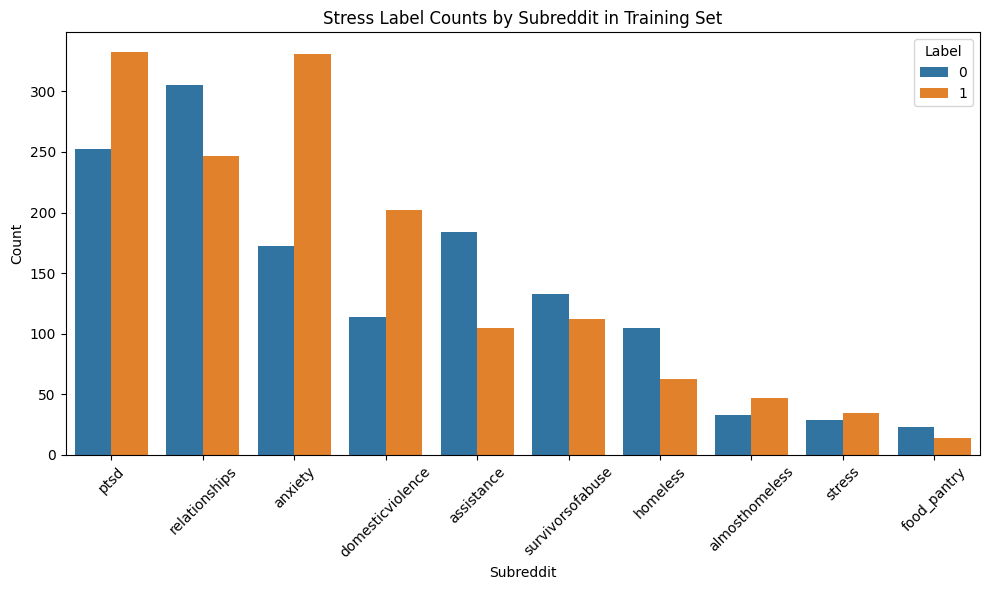

In [16]:
plot_label_counts_by_subreddit(train_df, "Training Set")

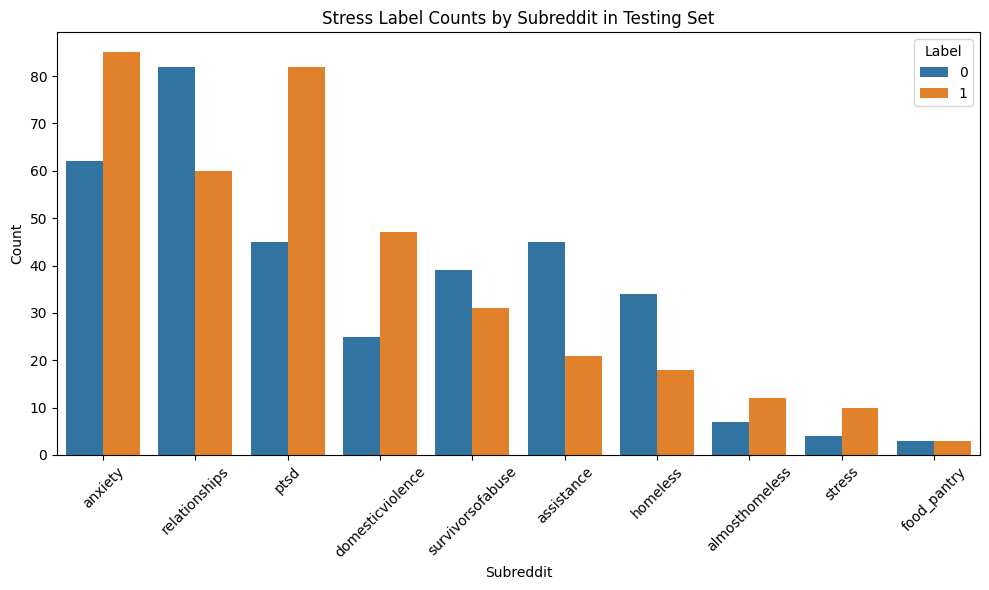

In [17]:
plot_label_counts_by_subreddit(test_df, "Testing Set")

### Text Length

In [18]:
def plot_text_length(df, df_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # histogram
    sns.histplot(df["lex_liwc_WC"], bins=40, kde=True)

    # set title and axes
    plt.title(f"Distribution of Word Count in {df_name}")
    ax.set_xlabel("Number of Words")
    ax.set_ylabel("Frequency")
    
    plt.tight_layout()

    # save plot
    plt.savefig(os.path.join(EDA_FOLDER_PATH, f"text_length_distribution_{df_name.lower()}.png"))
                
    plt.show()

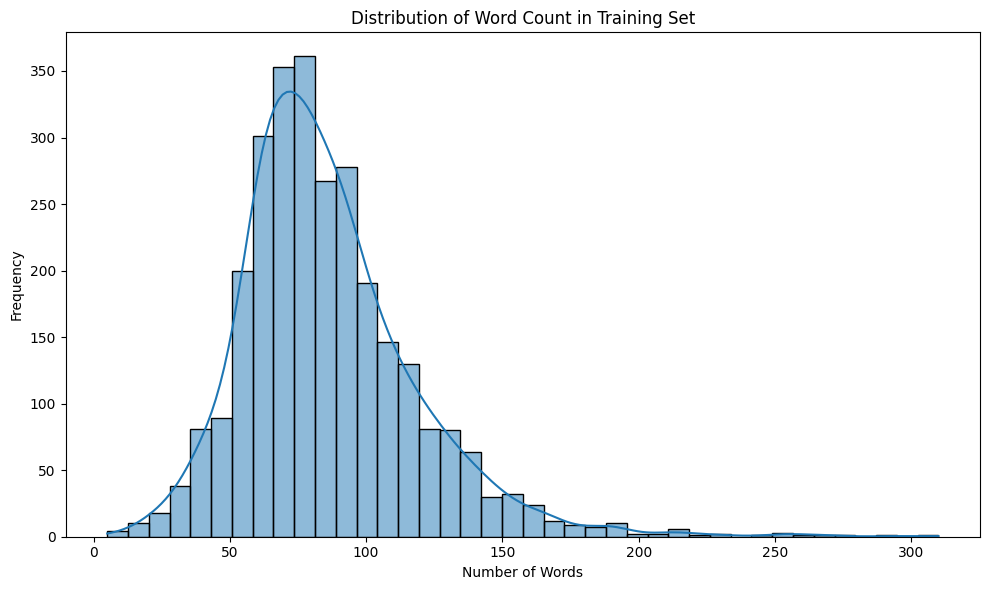

In [19]:
plot_text_length(train_df, "Training Set")

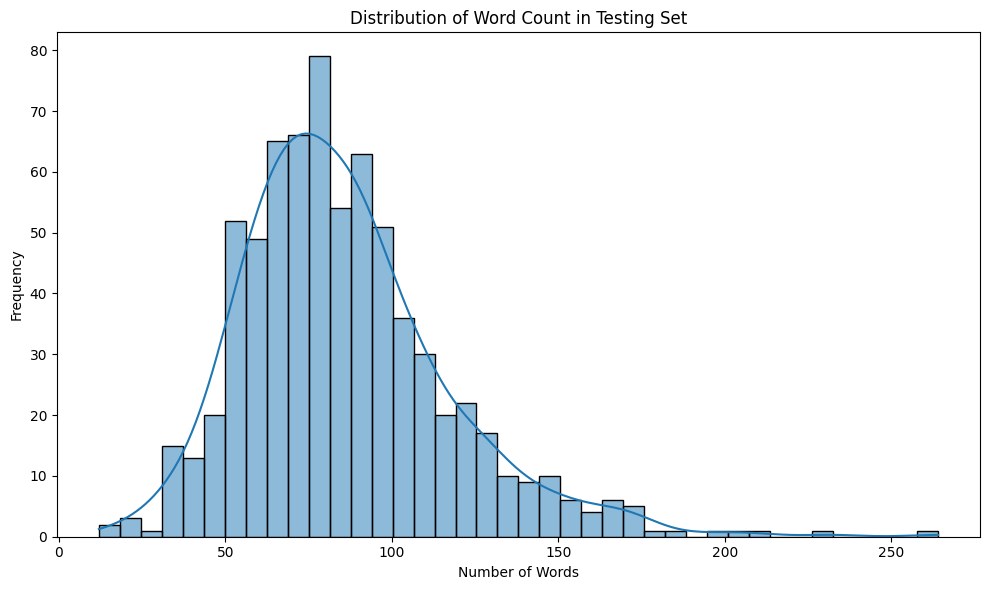

In [20]:
plot_text_length(test_df, "Testing Set")

In [21]:
def find_short_texts(df, min_text_length):
    df = df.copy(deep=True)
    df["text_length"] = df["text"].apply(lambda x: len(x.split()))
    df_short_texts = df[df["text_length"] < min_text_length]
    return df_short_texts.drop(["text_length"], axis=1)

In [22]:
MIN_TEXT_LENGTH = 5       # In terms of approximate number of words (separated by spaces)

In [23]:
find_short_texts(df=train_df, min_text_length=MIN_TEXT_LENGTH)

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
295,domesticviolence,7idwpv,"(10, 15)",#NAME?,31315,0,0.800000,1512724877,10,1.913846,...,1.2857,1.3333,1.0,1.75970,1.46364,1.96712,0.92,9,1.975077,0.343750
1592,anxiety,7ti69n,"[15, 20]",#NAME?,469,1,0.571429,1517114200,3,9.900000,...,1.0000,1.5000,1.0,1.82062,1.85000,1.77778,1.00,7,3.935556,-0.066667
2190,ptsd,9ut4zv,"[30, 35]",#NAME?,559,1,1.000000,1541543111,9,11.497297,...,1.1429,1.1429,1.0,1.80001,1.75833,1.85932,0.85,9,9.484459,-0.400000
2563,domesticviolence,8m1irj,"(15, 20)",#NAME?,29201,0,0.800000,1527252930,23,6.356558,...,1.0000,1.1250,1.0,1.66671,1.56279,1.95929,1.00,4,6.422609,0.220833


In [24]:
find_short_texts(df=test_df, min_text_length=MIN_TEXT_LENGTH)

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment


### Readability and Sentiment, By Stress Label

In [69]:
def plot_tone_against_sentiment_by_label(df, df_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # scatter plot by label
    sns.scatterplot(
        data=df,
        x="sentiment",
        y="lex_liwc_Tone",
        hue="label",
        palette={0: "#4C72B0", 1: "#DD8452"}
    )

    # set title, axes and legend
    plt.title(f"Tone and Sentiment of Text, By Stress Label ({df_name})")
    ax.set_xlabel("Sentiment Score")
    ax.set_ylabel("LIWC Tone")
    ax.legend(title="Label")

    # edit x axis
    ax.set_xlim(-1, 1)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.2))
    
    # edit y axis
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(10))
    
    plt.tight_layout()

    # save plot
    plt.savefig(os.path.join(EDA_FOLDER_PATH, f"tone_sentiment_by_label_{df_name.lower()}.png"))

    plt.show()

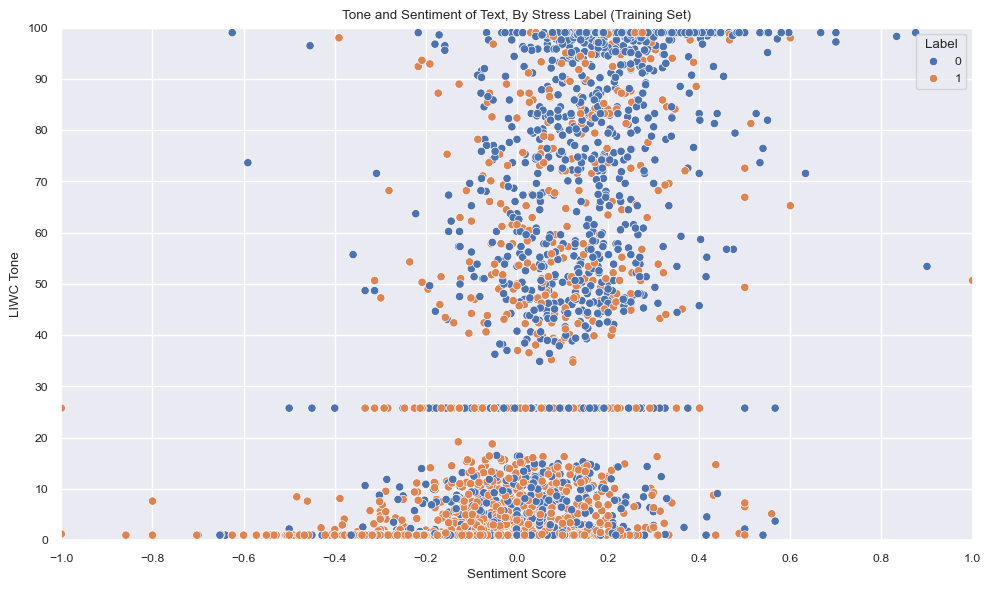

In [70]:
plot_tone_against_sentiment_by_label(train_df, "Training Set")

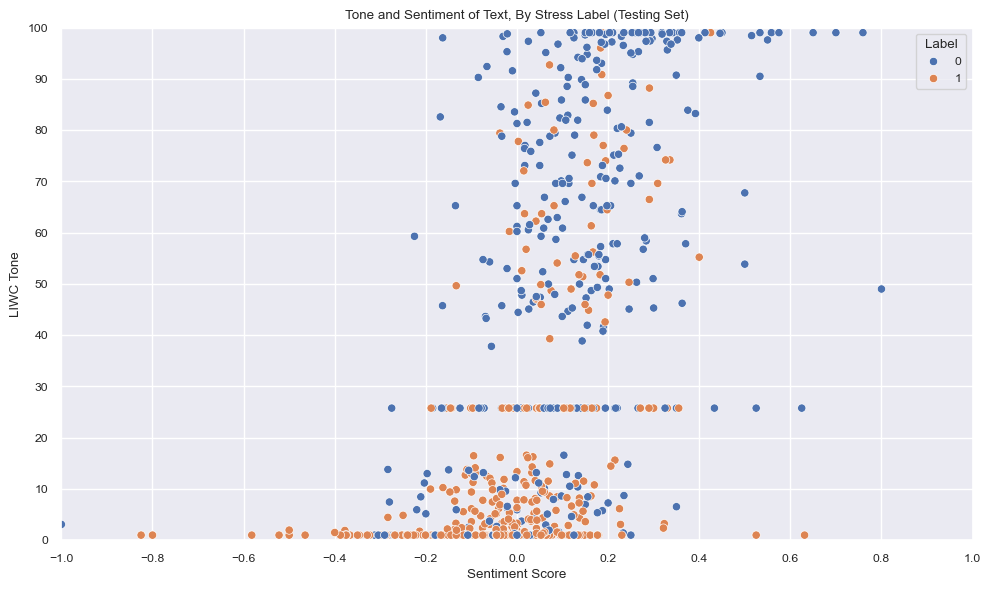

In [71]:
plot_tone_against_sentiment_by_label(test_df, "Testing Set")

## Data Processing

### Choose Columns and Rows

In [28]:
def drop_columns(df):
    return df.drop([
        "subreddit",
        "post_id",
        "sentence_range",
        "confidence",
        "social_timestamp",
        "social_karma"
    ], axis=1)

def remove_short_texts(df):
    df = df.copy()
    df["num_tokens"] = df["text"].str.split().str.len()
    df = df[df["num_tokens"] >= MIN_TEXT_LENGTH]
    df = df.drop(["num_tokens"], axis=1)

    return df    

In [29]:
train_df_processed = remove_short_texts(drop_columns(train_df))
test_df_processed = remove_short_texts(drop_columns(test_df))

### Create Features and Labels

In [30]:
MODEL_NAME = "google-bert/bert-base-cased"

In [31]:
def tokenise_dataframe(df, tokeniser_name, text_column="text"):
    tokeniser = AutoTokenizer.from_pretrained(tokeniser_name)

    encodings = tokeniser(
        df[text_column].tolist(),
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    encodings = {k: v.to(DEVICE) for k, v in encodings.items()}
    return encodings

def get_embeddings(df, model_name, batch_size=32):
    model = AutoModelForTextEncoding.from_pretrained(model_name).to(DEVICE)

    all_embeddings = list()
    with torch.no_grad():
        for i in range(0, len(df), batch_size):
            batch_texts = df[i: i + batch_size]
            encodings = tokenise_dataframe(batch_texts, model_name)
            inputs = {k: v.to(DEVICE) for k, v in encodings.items()}
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
    
            all_embeddings.append(cls_embeddings.cpu())

            torch.cuda.empty_cache()

            print(f"Finished getting embeddings for i = {i}")
            
    embedding_features = torch.cat(all_embeddings).numpy()
    embedding_cols = [f"cls_{i}" for i in range(embedding_features.shape[1])]
    embedding_df = pd.DataFrame(embedding_features, columns=embedding_cols)

    embedding_df.insert(loc=0, column="id", value=df["id"])
    embedding_df["label"] = df["label"].values
    
    return embedding_df

In [32]:
def get_features_and_labels(df, is_for_bert_encoding):
    if is_for_bert_encoding:
        features_and_labels = get_embeddings(df, MODEL_NAME)
    
    else:
        features_and_labels = df.drop(["text"], axis=1)

    features_and_labels["label"] = features_and_labels.pop("label")
    
    return features_and_labels

In [ ]:
train_df_processed_bert = get_features_and_labels(train_df_processed, is_for_bert_encoding=True)
test_df_processed_bert = get_features_and_labels(test_df_processed, is_for_bert_encoding=True)

train_df_processed_liwc = get_features_and_labels(train_df_processed, is_for_bert_encoding=False)
test_df_processed_liwc = get_features_and_labels(test_df_processed, is_for_bert_encoding=False)

In [ ]:
train_df_processed_bert.head()

In [ ]:
test_df_processed_bert.head()

In [ ]:
train_df_processed_liwc.head()

In [ ]:
test_df_processed_liwc.head()

In [ ]:
train_df_processed_bert["label"].value_counts(normalize=True)

In [ ]:
test_df_processed_bert["label"].value_counts(normalize=True)

In [ ]:
train_df_processed_liwc["label"].value_counts(normalize=True)

In [ ]:
test_df_processed_liwc["label"].value_counts(normalize=True)

In [ ]:
# save these dataframes
DATA_PATH = os.path.normpath(os.path.join("..", "data"))
os.makedirs(DATA_PATH, exist_ok=True)

train_df_processed_bert.to_csv(os.path.join(DATA_PATH, "train_bert.csv"), index=False)
test_df_processed_bert.to_csv(os.path.join(DATA_PATH, "test_bert.csv"), index=False)
train_df_processed_liwc.to_csv(os.path.join(DATA_PATH, "train_liwc.csv"), index=False)
test_df_processed_liwc.to_csv(os.path.join(DATA_PATH, "test_liwc.csv"), index=False)

## Training Last-Stage Classifiers

In [33]:
CM_FOLDER_PATH = os.path.normpath(os.path.join(PLOTS_FOLDER_PATH, "cm"))
os.makedirs(CM_FOLDER_PATH, exist_ok=True)

MODELS_FOLDER_PATH = os.path.normpath(os.path.join("..", "models"))
os.makedirs(MODELS_FOLDER_PATH, exist_ok=True)

In [34]:
def scale_features(X_train, X_test):
    # initialise scaler
    scaler = StandardScaler()

    # fit only on training data
    X_train_scaled = scaler.fit_transform(X_train)

    # transform test data using same scaler
    X_test_scaled = scaler.transform(X_test)

    # convert back to DataFrame
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    return X_train_scaled, X_test_scaled

In [35]:
def display_and_save_cm(cm: np.ndarray, filename: str) -> None:
    # make heat map of confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set_theme(font_scale=0.8)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    # save this heat map
    cm_file_path = os.path.join(CM_FOLDER_PATH, f"{filename}_cm.png")
    plt.savefig(cm_file_path, bbox_inches="tight")

    # display heat map
    print("Confusion Matrix:")
    plt.show()


def train_and_eval_classifier(model: ClassifierMixin, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, filename: str) -> ClassifierMixin:
    # train the model
    model.fit(X_train, y_train)

    # predict on test set
    y_preds = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)

    # calculate evaluation metrics
    acc = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds, pos_label=1)
    recall = recall_score(y_test, y_preds, pos_label=1)
    f1 = f1_score(y_test, y_preds, pos_label=1)
    cm = confusion_matrix(y_test, y_preds)

    # print evaluation metrics
    print(f"Accuracy: {round(acc * 100, 1)}%")
    print(f"Precision: {round(precision * 100, 1)}%")
    print(f"Recall: {round(recall * 100, 1)}%")
    print(f"F1 score: {round(f1 * 100, 1)}%")

    # display and save confusion matrix
    display_and_save_cm(cm=cm, filename=filename)
    
    # save fitted model
    with open(os.path.join(MODELS_FOLDER_PATH, f"{filename}_model.pkl"), "wb") as f:
        pickle.dump(model, f)

    return model, y_preds, y_pred_probs

### Load Data

In [36]:
train_bert = pd.read_csv(os.path.join(DATA_PATH, "train_bert.csv"))
test_bert = pd.read_csv(os.path.join(DATA_PATH, "test_bert.csv"))
train_liwc = pd.read_csv(os.path.join(DATA_PATH, "train_liwc.csv"))
test_liwc = pd.read_csv(os.path.join(DATA_PATH, "test_liwc.csv"))

In [37]:
y_train = train_bert["label"]
y_test = test_bert["label"]

X_train_bert = train_bert.drop(["id", "label"], axis=1)
X_test_bert = test_bert.drop(["id", "label"], axis=1)

X_train_liwc = train_liwc.drop(["id", "label"], axis=1)
X_test_liwc = test_liwc.drop(["id", "label"], axis=1)

X_train_concat = pd.concat([X_train_bert, X_train_liwc], axis=1)
X_test_concat = pd.concat([X_test_bert, X_test_liwc], axis=1)

### Scale Features

In [38]:
X_train_bert_scaled, X_test_bert_scaled = scale_features(X_train_bert, X_test_bert)
X_train_liwc_scaled, X_test_liwc_scaled = scale_features(X_train_liwc, X_test_liwc)
X_train_concat_scaled, X_test_concat_scaled = scale_features(X_train_concat, X_test_concat)

### BERT Embeddings

Accuracy: 70.6%
Precision: 70.9%
Recall: 73.2%
F1 score: 72.0%
Confusion Matrix:


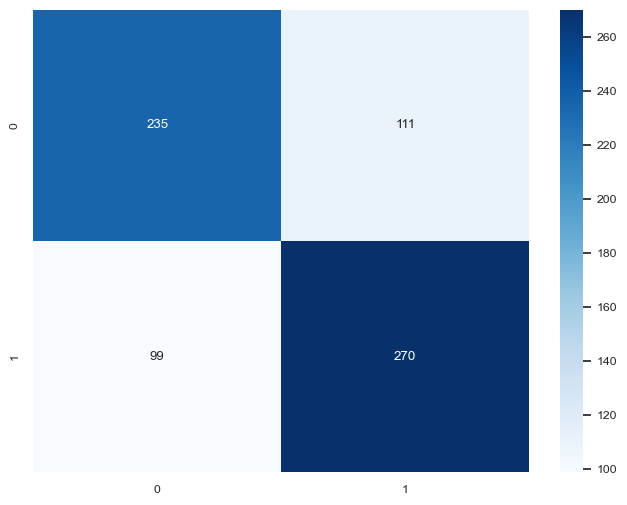

In [39]:
# initialise model
rf_bert = RandomForestClassifier(random_state=SEED)

# train and evaluate
rf_bert_fitted, rf_bert_preds, rf_bert_pred_probs = train_and_eval_classifier(model=rf_bert, X_train=X_train_bert_scaled, y_train=y_train, X_test=X_test_bert_scaled, y_test=y_test, filename="rf_bert")

### LIWC Features

Accuracy: 75.4%
Precision: 73.8%
Recall: 81.0%
F1 score: 77.3%
Confusion Matrix:


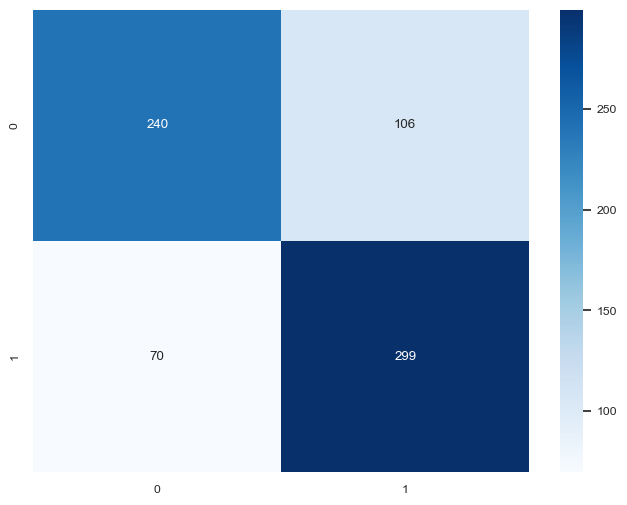

In [40]:
# initialise model
rf_liwc = RandomForestClassifier(random_state=SEED)

# train and evaluate
rf_liwc_fitted, rf_liwc_preds, rf_liwc_pred_probs = train_and_eval_classifier(model=rf_liwc, X_train=X_train_liwc_scaled, y_train=y_train, X_test=X_test_liwc_scaled, y_test=y_test, filename="rf_liwc")

### BERT + LIWC

#### Using All Features

Accuracy: 75.4%
Precision: 74.3%
Recall: 79.9%
F1 score: 77.0%
Confusion Matrix:


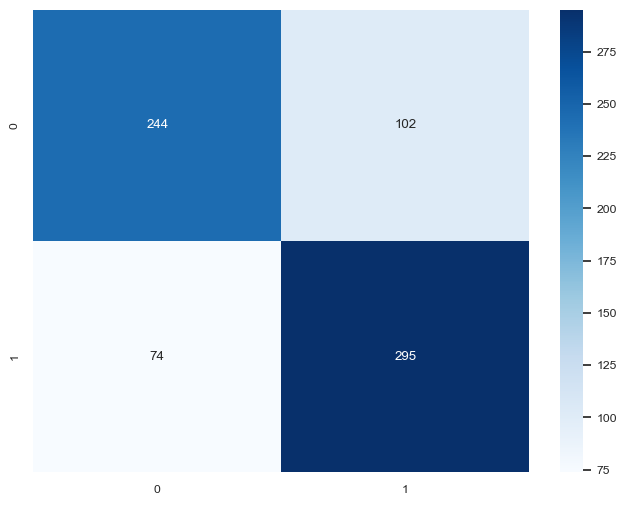

In [41]:
# initialise model
rf_concat = RandomForestClassifier(random_state=SEED)

# train and evaluate
rf_concat_fitted, rf_concat_preds, rf_concat_pred_probs = train_and_eval_classifier(model=rf_concat, X_train=X_train_concat_scaled, y_train=y_train, X_test=X_test_concat_scaled, y_test=y_test, filename="rf_concat")

#### Find Important Features (On Train Set)

In [42]:
explainer = shap.TreeExplainer(rf_concat)
shap_values_train = explainer.shap_values(X_train_concat_scaled)
shap_values_train_pos = shap_values_train[:, :, 1]

In [43]:
mean_shap_train = np.abs(shap_values_train_pos).mean(axis=0)
feature_importance_train = pd.DataFrame({
    "feature": X_train_concat_scaled.columns,
    "importance": mean_shap_train
}).sort_values("importance", ascending=False)

In [44]:
possible_k_values = list(range(10, 210, 10))
cv_f1_scores = list()

# loop through possible top k values and perform CV on training data
for num_impt_features in possible_k_values:
    print(f"Try k = {num_impt_features}")
    
    top_k = feature_importance_train["feature"].head(num_impt_features)

    rf = RandomForestClassifier(random_state=SEED)

    score = cross_val_score(
        rf,
        X_train_concat_scaled[top_k],
        y_train,
        cv=5,
        scoring="f1"
    ).mean()

    cv_f1_scores.append(score)

k_and_f1_scores = list(zip(possible_k_values, cv_f1_scores))
k_and_f1_scores.sort(key=lambda pair: pair[1], reverse=True)

Try k = 10
Try k = 20
Try k = 30
Try k = 40
Try k = 50
Try k = 60
Try k = 70
Try k = 80
Try k = 90
Try k = 100
Try k = 110
Try k = 120
Try k = 130
Try k = 140
Try k = 150
Try k = 160
Try k = 170
Try k = 180
Try k = 190
Try k = 200


In [45]:
k_and_f1_scores[0]

(70, np.float64(0.7898183039339728))

In [46]:
# get the most important feature names
chosen_num_impt_features = k_and_f1_scores[0][0]
top_feature_importance_train = feature_importance_train.head(chosen_num_impt_features)
important_features = list(top_feature_importance_train["feature"])

In [47]:
important_features

['lex_liwc_negemo',
 'lex_liwc_Tone',
 'lex_liwc_i',
 'sentiment',
 'lex_liwc_Clout',
 'lex_liwc_anx',
 'lex_dal_min_pleasantness',
 'lex_liwc_social',
 'lex_liwc_Authentic',
 'cls_193',
 'cls_490',
 'lex_liwc_anger',
 'cls_545',
 'lex_liwc_focuspresent',
 'cls_97',
 'cls_611',
 'cls_331',
 'cls_622',
 'cls_465',
 'cls_365',
 'cls_748',
 'cls_114',
 'lex_liwc_posemo',
 'cls_609',
 'cls_292',
 'cls_564',
 'cls_598',
 'lex_liwc_Dic',
 'cls_59',
 'cls_210',
 'cls_689',
 'cls_396',
 'cls_280',
 'cls_291',
 'cls_198',
 'cls_705',
 'cls_543',
 'lex_liwc_feel',
 'cls_194',
 'cls_196',
 'lex_liwc_sad',
 'cls_271',
 'cls_99',
 'cls_550',
 'cls_131',
 'cls_738',
 'cls_441',
 'cls_176',
 'cls_160',
 'cls_164',
 'cls_455',
 'cls_743',
 'cls_354',
 'cls_154',
 'cls_30',
 'cls_428',
 'cls_214',
 'cls_621',
 'cls_487',
 'cls_497',
 'cls_185',
 'cls_21',
 'cls_605',
 'cls_386',
 'cls_636',
 'lex_liwc_adverb',
 'cls_413',
 'cls_707',
 'cls_71',
 'cls_477']

### Select Important Features

In [48]:
X_train_concat_impt_features_scaled = X_train_concat_scaled[important_features]
X_test_concat_impt_features_scaled = X_test_concat_scaled[important_features]

In [49]:
X_train_concat_impt_features_scaled.shape

(2834, 70)

In [50]:
X_test_concat_impt_features_scaled.shape

(715, 70)

Accuracy: 76.1%
Precision: 74.6%
Recall: 81.3%
F1 score: 77.8%
Confusion Matrix:


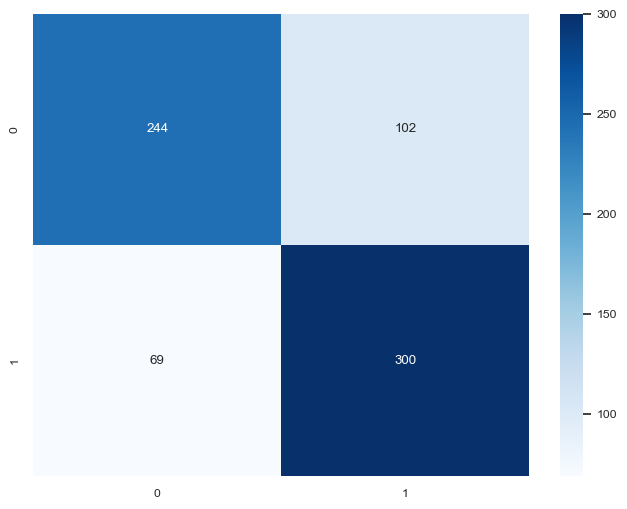

In [51]:
# initialise model
rf_concat_impt_features = RandomForestClassifier(random_state=SEED)

# train and evaluate
rf_concat_impt_features_fitted, rf_concat_impt_features_preds, rf_concat_impt_features_pred_probs = train_and_eval_classifier(model=rf_concat_impt_features, X_train=X_train_concat_impt_features_scaled, y_train=y_train, X_test=X_test_concat_impt_features_scaled, y_test=y_test, filename="rf_concat_impt_features")

## Explainability of Final Approach: SHAP Values

In [52]:
explainer = shap.TreeExplainer(rf_concat_impt_features)
shap_values_test = explainer.shap_values(X_test_concat_impt_features_scaled)
shap_values_test_pos = shap_values_test[:, :, 1]

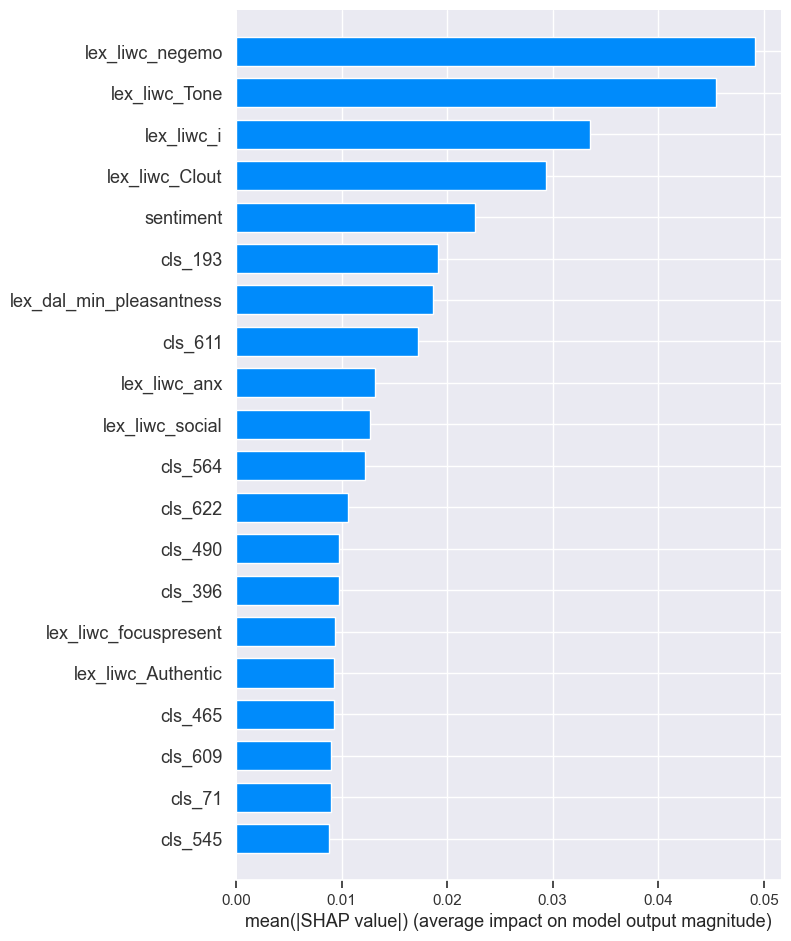

In [53]:
shap.summary_plot(
    shap_values_test_pos,
    X_test_concat_impt_features_scaled,
    plot_type="bar"
)

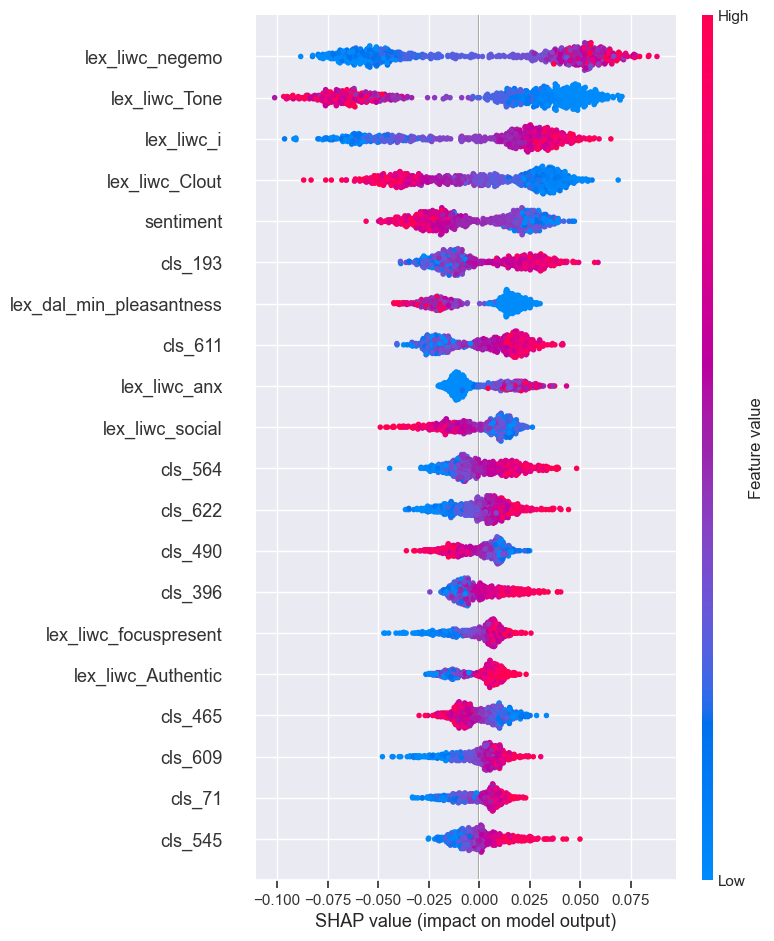

In [54]:
shap.summary_plot(
    shap_values_test_pos,
    X_test_concat_impt_features_scaled
)

## Error Analysis

In [55]:
ERROR_ANALYSIS_PATH = os.path.normpath(os.path.join(PLOTS_FOLDER_PATH, "error_analysis"))
os.makedirs(ERROR_ANALYSIS_PATH, exist_ok=True)

In [56]:
ids = test_bert["id"]

pred_confidences = [probs[pred_class] for probs, pred_class in zip(rf_concat_impt_features_pred_probs, rf_concat_impt_features_preds)]

ids_and_preds_df = pd.DataFrame({
    "id": ids,
    "pred": rf_concat_impt_features_preds,
    "pred_confidence": pred_confidences
})

error_analysis_df = pd.merge(test_df, ids_and_preds_df, on="id")
error_analysis_df = error_analysis_df[[
    "id",
    "subreddit",
    "text",
    "pred",
    "pred_confidence",
    "label",
    "confidence"
]]
error_analysis_df["pred_correctness"] = error_analysis_df["pred"] == error_analysis_df["label"]

In [57]:
error_analysis_df.head()

,id,subreddit,text,pred,pred_confidence,label,confidence,pred_correctness
0,896,relationships,"Its like that, if you want or not.“ ME: I have...",0,0.67,0,0.8,True
1,19059,anxiety,I man the front desk and my title is HR Custom...,0,0.54,0,1.0,True
2,7977,ptsd,We'd be saving so much money with this new hou...,1,0.56,1,1.0,True
3,1214,ptsd,"My ex used to shoot back with ""Do you want me ...",1,0.57,1,0.5,True
4,1965,relationships,I haven’t said anything to him yet because I’m...,1,0.58,0,0.8,False


### Performance by Subreddit

In [58]:
metrics_by_subreddit_list = list()

for sub, group in error_analysis_df.groupby("subreddit"):
    y_true = group["label"]
    y_pred = group["pred"]
    
    metrics_by_subreddit_list.append({
        "subreddit": sub,
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    })

metrics_by_subreddit_df = pd.DataFrame(metrics_by_subreddit_list)
metrics_by_subreddit_df = metrics_by_subreddit_df.sort_values("f1", ascending=False)

In [59]:
metrics_by_subreddit_df.head()

,subreddit,accuracy,f1
6,ptsd,0.826772,0.870588
3,domesticviolence,0.805556,0.857143
8,stress,0.785714,0.842105
1,anxiety,0.755102,0.814433
4,food_pantry,0.833333,0.800000


In [60]:
# pivot longer
metrics_by_subreddit_pivot_longer_df = metrics_by_subreddit_df.melt(
    id_vars="subreddit",
    value_vars=["accuracy", "f1"],
    var_name="metric",
    value_name="score"
)

metrics_by_subreddit_pivot_longer_df.head()

,subreddit,metric,score
0,ptsd,accuracy,0.826772
1,domesticviolence,accuracy,0.805556
2,stress,accuracy,0.785714
3,anxiety,accuracy,0.755102
4,food_pantry,accuracy,0.833333


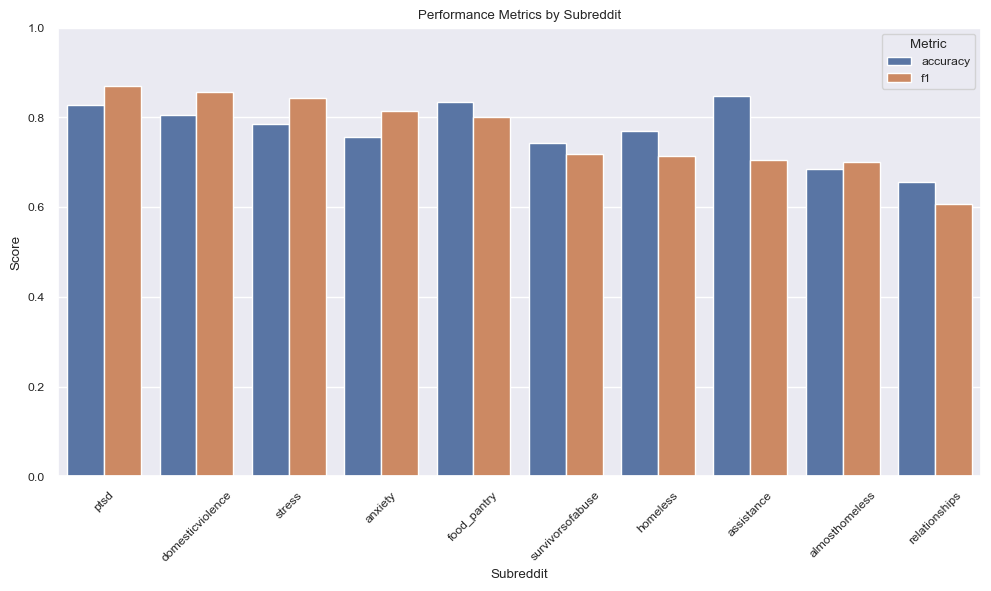

In [61]:
fig, ax = plt.subplots(figsize=(10, 6))

# grouped bar chart
sns.barplot(
    data=metrics_by_subreddit_pivot_longer_df,
    x="subreddit",
    y="score",
    hue="metric"
)

# set title, axes and legend
plt.title(f"Performance Metrics by Subreddit")
ax.set_xlabel("Subreddit")
ax.set_ylabel("Score")
ax.legend(title="Metric")

# edit x axis
plt.xticks(rotation=45)

# edit y acis
ax.set_ylim(0, 1)

plt.tight_layout()

# save plot
plt.savefig(os.path.join(ERROR_ANALYSIS_PATH, f"performance_by_subreddit.png"))

plt.show()

### Label and Prediction Confidences

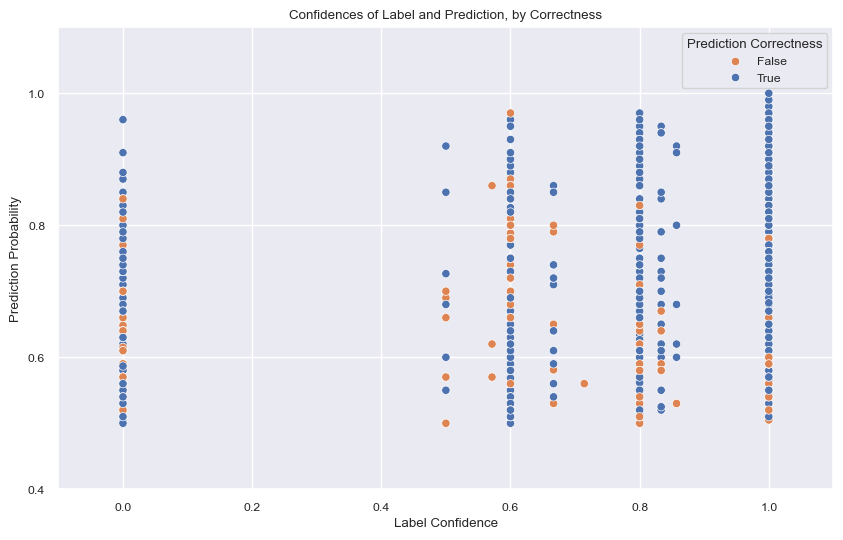

In [68]:
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot by label
sns.scatterplot(
    data=error_analysis_df,
    x="confidence",
    y="pred_confidence",
    hue="pred_correctness",
    palette={0: "#DD8452", 1: "#4C72B0"}
)

# set title, axes and legend
plt.title(f"Confidences of Label and Prediction, by Correctness")
ax.set_xlabel("Label Confidence")
ax.set_ylabel("Prediction Probability")
ax.legend(title="Prediction Correctness")

# edit x axis
ax.set_xlim(-0.1, 1.1)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.2))

# edit y axis
ax.set_ylim(0.4, 1.1)
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.2))

# save plot
plt.savefig(os.path.join(ERROR_ANALYSIS_PATH, f"confidence_scatter_plot.png"))

plt.show()

### Finding Confident but Wrong Predictions

In [72]:
# we want test samples that have a high label confidence, high prediction probability
# but incorrect prediction
MIN_LABEL_CONFIDENCE = 0.8
MIN_PRED_CONFIDENCE = 0.8

In [78]:
error_analysis_df_confident_mistakes = error_analysis_df[
    (error_analysis_df["confidence"] >= MIN_LABEL_CONFIDENCE)
    & (error_analysis_df["pred_confidence"] >= MIN_PRED_CONFIDENCE)
    & (~error_analysis_df["pred_correctness"])
]

In [79]:
error_analysis_df_confident_mistakes

,id,subreddit,text,pred,pred_confidence,label,confidence,pred_correctness
85,29364,ptsd,I just wanted to say thank you to everyone tha...,1,0.81,0,1.0,False
634,5899,anxiety,"I needed to run some errands, but it was a Sat...",1,0.81,0,0.8,False
651,739,survivorsofabuse,"When I was 17, my mom turned her attacks on my...",1,0.83,0,0.8,False


In [80]:
for _, row in error_analysis_df_confident_mistakes.iterrows():
    text, pred, label = row["text"], row["pred"], row["label"]
    print(f"Prediction: {pred} | Label: {label}")
    print("Text:")
    print(text)
    print()

Prediction: 1 | Label: 0
Text:
I just wanted to say thank you to everyone that posts on here. I just found this subreddit yesterday and reading all of your guys' posts have made me feel so much less alone. Knowing that other people understand what I'm going through for some reason has helped me tremendously. Particularly a post that someone made about feeling like their trauma isnt real and like convincing yourself that it didnt happen. I have felt like I'm crazy for years because I was in such deep denial about what happened to me.

Prediction: 1 | Label: 0
Text:
I needed to run some errands, but it was a Saturday afternoon when stores were usually too busy for me, but I felt so great I decided to try it. I went into a busy store and actually waited in line to pay infont of a very obnoxious couple who didn't understAnd personal space. I was totally fine. I couldn't believe it. In other situations i'd have to avoid the store all together or walk around the store until the line went dow